<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/sharpeRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
from scipy.optimize import minimize

# Config display
%config InlineBackend.figure_format = 'retina'

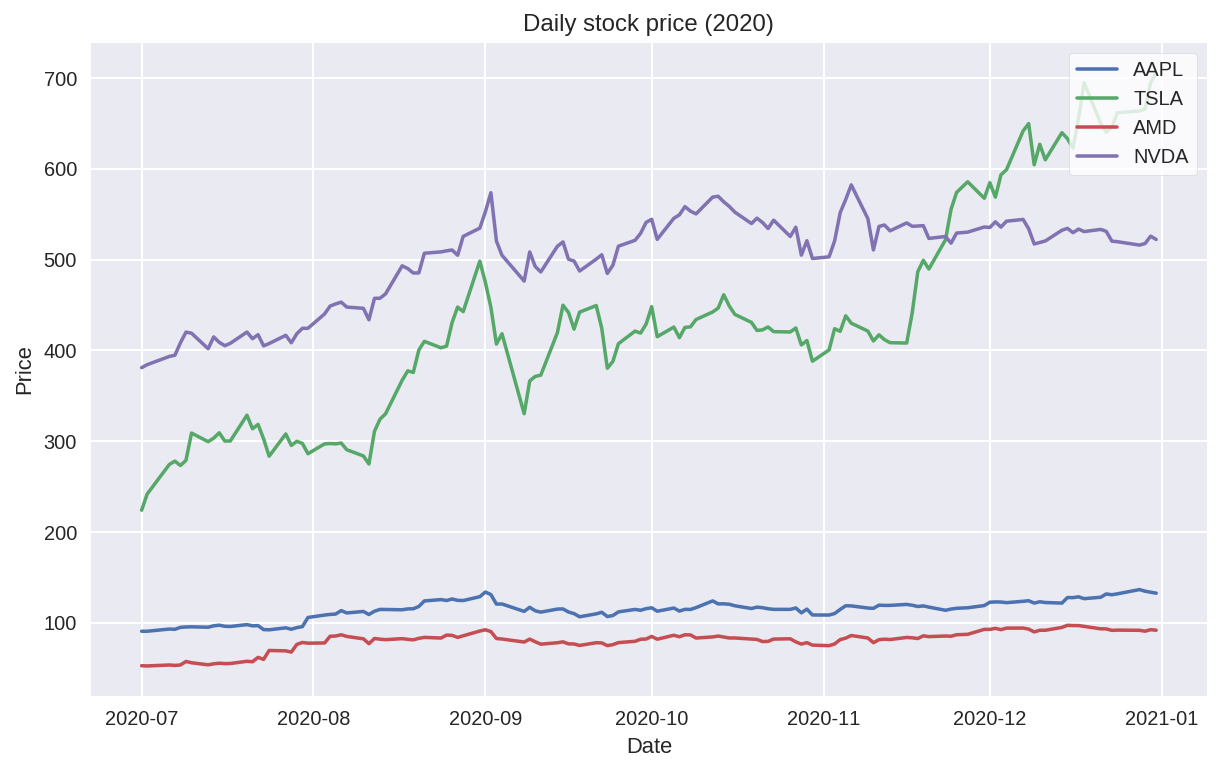

In [2]:
# Get stocks data
stockList = ['AAPL', 'TSLA', 'AMD', 'NVDA']
df = []

for stock in stockList:
  data = pdr.get_data_yahoo(stock,
                            start = '2020-07-01',
                            end = '2020-12-31')
  data = data[['Adj Close']]
  data = data.rename(columns = {'Adj Close': stock})
  df.append(data)

# Combine stocks data
df = pd.concat(df, axis = 1)

# Plot stocks price
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Daily stock price (2020)')
  plt.xlabel('Date')
  plt.ylabel('Price')

  for stock in df.columns:
    plt.plot(df[stock], label = stock)

  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper right')
  plt.show()

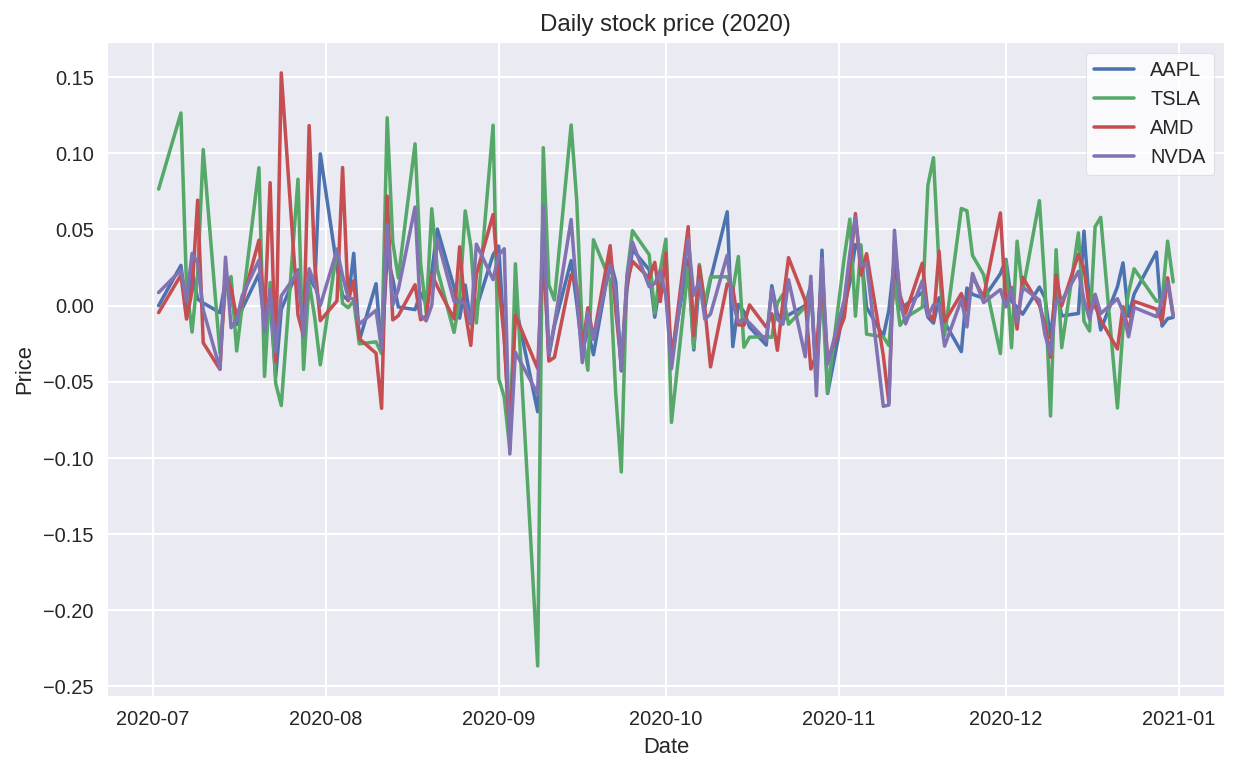

In [3]:
# Calculate log returns
returns = np.log(1 + df.pct_change()) #Plus 1 into precent changed formula
returns = returns.dropna(how = 'all', axis = 0) #Drop first date

# Plot log returns
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Daily stock price (2020)')
  plt.xlabel('Date')
  plt.ylabel('Price')

  for stock in returns.columns:
    plt.plot(returns[stock], label = stock)

  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper right')
  plt.show()

In [4]:
# Create random weights for stocks
weights = np.random.random(returns.shape[1])
weights /= np.sum(weights) #To get 100% of weights

# Calculate annualised expected return
expReturns = np.sum((returns.mean() * weights) * returns.shape[0]) #Multiply by trading days

# Calculate annualised expected volatility
expVol = np.sqrt(np.dot(weights.T,
                        np.dot(returns.cov() * returns.shape[0],
                               weights)))

# Calculate Sharpe Ratio
riskFree = 0.001

sharpeRatio = (expReturns - riskFree) / expVol

# Print results
print(f'Weights: {dict(zip(returns.columns, np.round(weights, 2)))}')
print(f'Expected return: {expReturns:.2f}')
print(f'Expected volatility: {expVol:.2f}')
print(f'Sharpe Ratio: {sharpeRatio:.2f}')

Weights: {'AAPL': 0.26, 'TSLA': 0.45, 'AMD': 0.2, 'NVDA': 0.08}
Expected return: 0.76
Expected volatility: 0.35
Sharpe Ratio: 2.14


In [5]:
# Define Sharpe Ratio function
def SharpeRatio(data, n, riskFree):
  results = []

  for i in range(n):
    
    # Simulation
    weights = np.random.random(data.shape[1])
    weights /= np.sum(weights)
    expRet = np.sum((data.mean() * weights) * data.shape[0])
    expVol = np.sqrt(np.dot(weights.T,
                            np.dot(data.cov() * data.shape[0],
                                   weights)))
    
    # Sharpe Ratio
    ratio = (expRet - riskFree) / expVol

    # Summary table
    result = {'Sharpe Ratio': [ratio],
              'Return': [expRet],
              'Volatility': [expVol]}
    
    weights = pd.DataFrame([weights], columns = data.columns)
    result = pd.DataFrame(result)
    result = pd.concat([result, weights], axis = 1)
    results.append(result)

  return pd.concat(results, axis = 0).reset_index(drop = True)

# Monte Carlo simulation
simulation = SharpeRatio(returns, 5000, 0.001)
simulation

,Sharpe Ratio,Return,Volatility,AAPL,TSLA,AMD,NVDA
0,1.951986,0.581236,0.297254,0.273395,0.175381,0.423788,0.127437
1,1.993014,0.663123,0.332222,0.186131,0.366460,0.127027,0.320383
2,2.132765,0.701020,0.328222,0.228561,0.345292,0.345971,0.080176
3,2.108238,0.669968,0.317311,0.314583,0.323817,0.268075,0.093525
4,1.991632,0.581988,0.291715,0.418627,0.224523,0.217925,0.138925
...,...,...,...,...,...,...,...
4995,1.911345,0.585355,0.305730,0.202862,0.257968,0.174604,0.364566
4996,1.824951,0.503367,0.275277,0.457366,0.121239,0.238026,0.183369
4997,2.077797,0.718449,0.345293,0.041060,0.367197,0.393244,0.198500
4998,1.886991,0.593634,0.314063,0.071202,0.195577,0.460051,0.273171


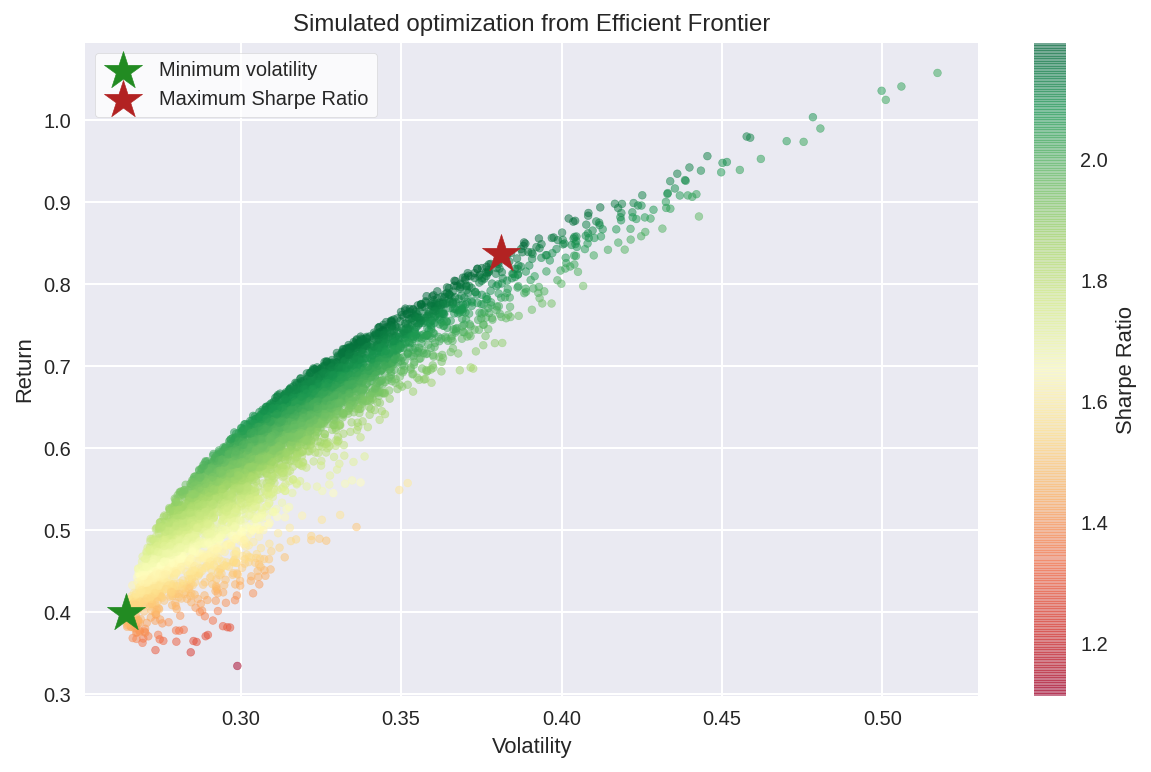

In [6]:
# Find minimum volatility
minVol = simulation.loc[simulation['Volatility'].idxmin()]

# Find maximum Sharpe Ratio
maxShp = simulation.loc[simulation['Sharpe Ratio'].idxmax()]

# Plot simulation
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Simulated optimization from Efficient Frontier')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  
  # Plot simulation
  plt.scatter(x = simulation['Volatility'], y = simulation['Return'],
              c = simulation['Sharpe Ratio'], cmap = 'RdYlGn',
              marker = 'o', s = 15, alpha = 0.5)
  
  plt.colorbar(label = 'Sharpe Ratio')
  
  # Plot minimum volatility
  plt.scatter(x = minVol['Volatility'], y = minVol['Return'],
              c = 'forestgreen', marker = '*', s = 400, label = 'Minimum volatility')

  # Plot maximum Sharpe Ratio
  plt.scatter(x = maxShp['Volatility'], y = maxShp['Return'],
              c = 'firebrick', marker = '*', s = 400, label = 'Maximum Sharpe Ratio')
  
  
  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper left')
  plt.show()

In [ ]:
# Print minimum Volatility
minVol

Sharpe Ratio    1.468094
Return          0.388385
Volatility      0.263870
AAPL            0.590196
TSLA            0.004102
AMD             0.129692
NVDA            0.276010
Name: 1638, dtype: float64

In [ ]:
# Print maximum Sharpe Ratio
maxShp

Sharpe Ratio    2.195194
Return          0.798805
Volatility      0.363433
AAPL            0.188951
TSLA            0.466747
AMD             0.342856
NVDA            0.001446
Name: 1508, dtype: float64

In [7]:
# Optimization
# Define Shapre Ratio function
def SharpeRatio(weights):
  weights = np.array(weights)
  expRet = np.sum((returns.mean() * weights) * returns.shape[0])
  expVol = np.sqrt(np.dot(weights.T,
                          np.dot(returns.cov() * returns.shape[0],
                                 weights)))
  ratio = (expRet - 0.001) / expVol
  results = np.array([expRet, expVol, ratio])
  return results

# Define maximum Sharpe Ratio function
def maxSharpe(weights):
  return -SharpeRatio(weights)[2] #Inversed minimum to find maximum

# Define minimum volatility function
def minVolat(weights):
  return SharpeRatio(weights)[1]

# Define constraints
def constraint(weights):
    return np.sum(weights) - 1

# Initial guess
init = returns.shape[1] * [1 / returns.shape[1]] #Equal weights

# Boundaries between 0-1
bounds = tuple((0., 1.) for i in range(returns.shape[1]))

# Constraints
constraints = {'type': 'eq', 'fun': constraint}

In [8]:
# Perform to optimize volatility
optVolFun = minimize(minVolat, init, method = 'SLSQP',
                     bounds = bounds, constraints = constraints)

# Results
print(dict(zip(stockList, optVolFun.x)))

optVol = SharpeRatio(optVolFun.x)
print(optVol)

{'AAPL': 0.5869882937664417, 'TSLA': 4.228388472693467e-18, 'AMD': 0.12140533693032167, 'NVDA': 0.2916063693032367}
[0.38276493 0.26375173 1.44744046]


In [9]:
# Perform to optimize Sharpe Ratio
optSharpeFun = minimize(maxSharpe, init, method = 'SLSQP',
                        bounds = bounds, constraints = constraints)

# Results
print(dict(zip(stockList, optSharpeFun.x)))

optSharpe = SharpeRatio(optSharpeFun.x)
print(optSharpe)

{'AAPL': 0.1342174039613112, 'TSLA': 0.4935350516992712, 'AMD': 0.37224754433941765, 'NVDA': 0.0}
[0.82462851 0.37482053 2.19739434]


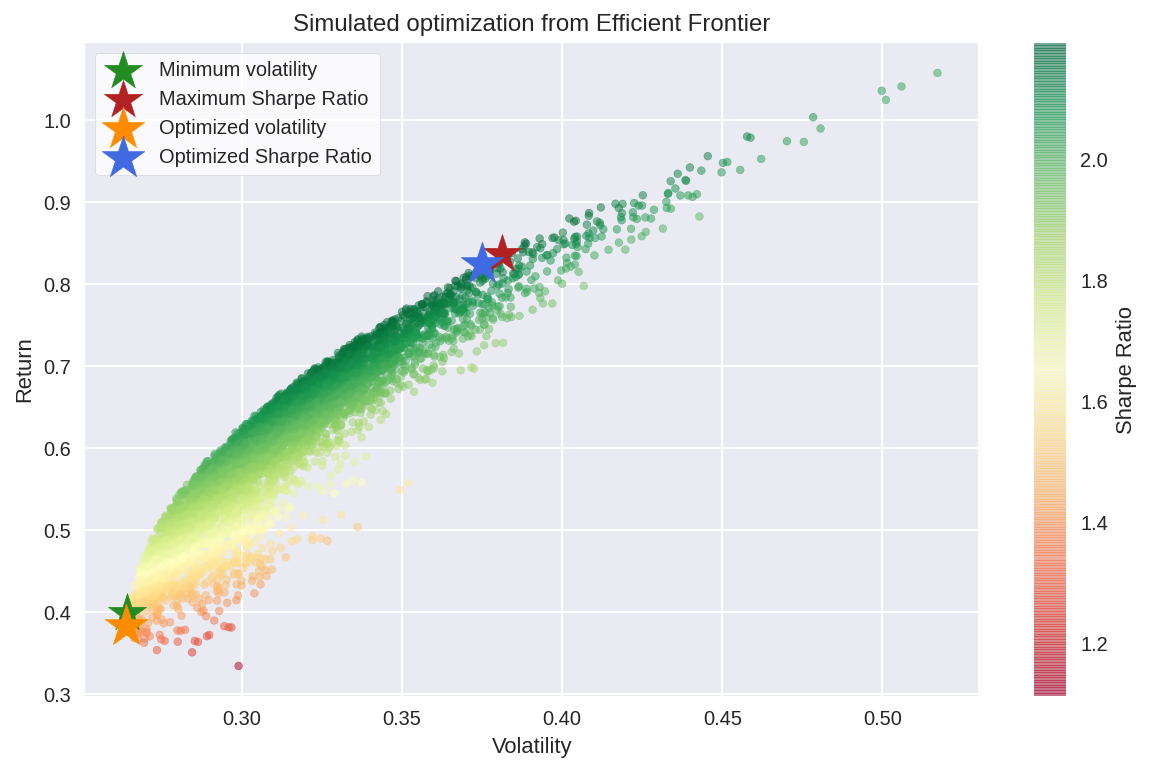

In [10]:
# Plot simulation
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Simulated optimization from Efficient Frontier')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  
  # Plot simulation
  plt.scatter(x = simulation['Volatility'], y = simulation['Return'],
              c = simulation['Sharpe Ratio'], cmap = 'RdYlGn',
              marker = 'o', s = 15, alpha = 0.5)
  
  plt.colorbar(label = 'Sharpe Ratio')
  
  # Plot minimum volatility
  plt.scatter(x = minVol['Volatility'], y = minVol['Return'],
              c = 'forestgreen', marker = '*', s = 400, label = 'Minimum volatility')

  # Plot maximum Sharpe Ratio
  plt.scatter(x = maxShp['Volatility'], y = maxShp['Return'],
              c = 'firebrick', marker = '*', s = 400, label = 'Maximum Sharpe Ratio')
  
  # Plot optimized volatility
  plt.scatter(x = optVol[1], y = optVol[0],
              c = 'darkorange', marker = '*', s = 500, label = 'Optimized volatility')

  # Plot optimized Sharpe Ratio
  plt.scatter(x = optSharpe[1], y = optSharpe[0],
              c = 'royalblue', marker = '*', s = 500, label = 'Optimized Sharpe Ratio')
  
  plt.legend(frameon = True, facecolor = 'white',
             loc = 'upper left')
  plt.show()